<a href="https://colab.research.google.com/github/Subhasishbasak/Data-Mining-Machine-Learning/blob/master/Reinforcement_learning_Racetrack_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import namedtuple, defaultdict
import random
import time
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

Environment (A race-track in our case)<br>
The race-track is stored as a string, where the symbols denote the following:
- ' '  : Blocked track
- X    : Racing track
- F    : Finishing locations
- S    : Starting locations



In [0]:
MAX_SPEED = 4
N_ACTIONS = 3  # number of actions along x and y: 0, 1, -1

In [0]:
track2 = """
                                 
                XXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
              XXXXXXXXXXXXXXXX   
              XXXXXXXXXXXXX      
              XXXXXXXXXXXX       
              XXXXXXXXXX         
              XXXXXXXXX          
             XXXXXXXXXX          
            XXXXXXXXXXX          
           XXXXXXXXXXXX          
          XXXXXXXXXXXXX          
         XXXXXXXXXXXXXX          
        XXXXXXXXXXXXXXX          
       XXXXXXXXXXXXXXXX          
      XXXXXXXXXXXXXXXXX          
     XXXXXXXXXXXXXXXXXX          
    XXXXXXXXXXXXXXXXXXX          
   XXXXXXXXXXXXXXXXXXXX          
  XXXXXXXXXXXXXXXXXXXXX          
 XXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
SSSSSSSSSSSSSSSSSSSSSSS          
"""

In [0]:
track1 = """
                  
   XXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
 XXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXX        
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
   XXXXXX         
   XXXXXX         
   SSSSSS         
"""

In [0]:
track3 = """
                               
   XXXXXXXXXXXXXXXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXXXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXXXXXXXXXXXXXXF 
 XXXXXXXXXXXXXXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXXXXXXXX        
XXXXXXXXXXXXXXXXXXXXXX         
XXXXXXXXXXXXXXXXXXXXXX         
  XXXXXXXXXXXXXXXXXXXXXX       
     XXXXXXXXXXXXXXXXXXXXXX    
       XXXXXXXXXXXXXXXXXXXXXX  
         XXXXXXXXXXXXXXXXXXXXXX
         XXXXXXXXXXXXXXXXXXXXXX
         XXXXXXXXXXXXXXXXXXXXX 
        XXXXXXXXXXXXXXXXXXXXX  
       XXXXXXXXXXXXXXXXXXXXX   
      XXXXXXXXXXXXXXXXXXXXX    
     XXXXXXXXXXXXXXXXXXXXX     
   XXXXXXXXXXXXXXXXXXXXX       
  XXXXXXXXXXXXXXXXXXXXX        
  XXXXXXXXXXXXXXXXXXXXX        
     XXXXXXXXXXXXXXXXXXXX      
      XXXXXXXXXXXXXXXXXXXX     
        XXXXXXXXXXXXXXXXXXXX   
          XXXXXXXXXXXXXXXXXXXX 
           XXXXXXXXXXXXXXXXXXXX
            XXXXXXXXXXXXXXXXXXX
          XXXXXXXXXXXXXXXXXXXX 
       XXXXXXXXXXXXXXXXXXX     
     XXXXXXXXXXXXXXXXXXX       
   XXXXXXXXXXXXXXXXXXX         
   SSSSSSSSSSSSSSSSSSS         
"""

We use `namedtuples` to construct our model components, viz. State, Action and a Transition.<br>
- `State` : a 4D tuple stores, the $x$ co-ordinate, $y$ co-ordinate, vertical speed and horizontal speed respectively.
- `Action` : a 2D tuple stores the "change in velocity"/"acceleration" in the vertical and horizontal direction respectively.
- `Transition` : a 4D tuple stores the initial state, action, the obtained reward and the next state respectively.

In [0]:
State = namedtuple('State', ['x', 'y', 'vx', 'vy']) 
Action = namedtuple('Action', ['ax', 'ay']) 
Transition = namedtuple('Transition', ['state1', 'action', 'reward', 'state2'])

Next we create the environment as a class object named `Racetrack`. An environment class supports the following operations:
-    `Racetrack._track_cell(x, y)`: Returns the tpye of a cell given its co-ordinates. i.e. either of ' ', X, F, S.
-    `Racetrack._is_on_track(state)`: Boolean return. Returns *True* if the state is on the Racing track (X).
-    `Racetrack._has_finished(state)`: Boolean return. Returns *True* if state is in Finishing locations.
-    `Racetrack._transition(state, action)`: Returns a reward, the next state and termination status (r, s', term)
-    `Racetrack.reset()`: Returns a state at the Starting location with both the velocity components zero.
- `Racetrack.step(action)`: Updates the current state and returns a tuple of state, reward, termination status and _
- `Racetrack.track_as_np()`: Converts the track in a suitable np array for visualization purpose


In [0]:
class Racetrack(object):
    def __init__(self, track_str):
        rows = track_str.split('\n')
        rows = rows[1:-1]                         #  remove first and last rows, required for our given representation of the racetrack
        rows = rows[::-1]                         #  flip vertically so [0,0] corresponds to bottom left corner
        cells = map(list, rows)                   #  convert rows of strings to rows of chars
        self._track = np.array(list(cells))
        
        self._state = None
        
        self.actions = []                         # defines all possible actions
        for ax in [-1, 0, 1]:
            for ay in [-1, 0, 1]:
                self.actions.append(Action(ax, ay))

    def _track_cell(self, x, y):
        max_y = self._track.shape[0] - 1
        max_x = self._track.shape[1] - 1
        
        if x < 0 or x > max_x:
            return ' '
        if y < 0 or y > max_y:
            return ' '
        
        return self._track[y, x]
        
    def _is_on_track(self, state):
        assert state.vx <= MAX_SPEED              # This asserts the velocity components are within [0,4]
        assert state.vx >= 0
        assert state.vy <= MAX_SPEED
        assert state.vy >= 0
        
        return self._track_cell(state.x, state.y) != ' '
    
    def _has_finished(self, state):
        return self._track_cell(state.x, state.y) == 'F'

    def _transition(self, state, action):
        
        vx2 = state.vx + action.ax                # Updates the car speed with new co-ordinates vx2,vy2
        vy2 = state.vy + action.ay
        
        vx2 = np.clip(vx2, 0, MAX_SPEED)          # Clipping is done to restrict the maximum speed to 4
        vy2 = np.clip(vy2, 0, MAX_SPEED)
        
        if vx2 == 0 and vy2 == 0:                 # Keeps the speed unchanged if both the new variance components are zero
            vx2, vy2 = state.vx, state.vy         # (Since standing at some position can not be a part of the optimal policy)  
        
        x2 = state.x + vx2                        # Updates the car position with new co-ordinates x2,y2
        y2 = state.y + vy2
        
        term = False                              # term refers to the termination status. term = True if it reaches the finishing positions 
        collision = False                         # Collision refers to the car hitting the boundary (either the horizontal or vertical boundary)
        s2 = State(x2, y2, vx2, vy2)
        if self._has_finished(s2):
          r = 0
          term = True
        if not self._is_on_track(s2):             # Checks whether the car hits the boundary 
          collision = True                        
          s2 = self.reset()                       # Initializes a new state in the starting positions with zero velocities, if collision occurs
          r = -5                                  # We assign a reward -5, if the car hits the boundary
        else:
          r = -1                                  # We assign a reward -1, for every step until the car crosses the finish line

        return r, s2, term

    def reset(self):                              
        max_x = self._track.shape[1]
        while True:
            x = random.randint(0, max_x)         # New starting state is selected randomly 
            vx = 0                               # New velocity components are set to zero     
            vy = 0
            s = State(x=x, y=0, vx=vx, vy=vy)
            if self._is_on_track(s):             # Checks the condition that the new randomly generated starting point is on-track
                break
        self._state = s
        return s
        
    def step(self, action):
        r, s2, term = self._transition(self._state, action)
        self._state = s2
        return s2, r, term, _
    
    def track_as_np(self):                    
        _track = self._track
        track_np = np.zeros_like(_track, dtype=int)
        track_np[_track == 'S'] = 1
        track_np[_track == 'X'] = 2
        track_np[_track == 'F'] = 3
        return track_np

## Monte Carlo control

Next we create another class over the environment class to perform the **Monte carlo control** with *Exploring starts*, where each of the startig points have a non negative probability to get selected. This class supports the following operations <br>
- `OnPolicyMC.generate_episode(policy)`: Given a policy this method generates an episode as a list of Transitions
- `OnPolicyMC.epsilon_greedy_policy(state)`: Here we also implement the $\epsilon$-$greedy$ strategy for policy improvement. Under the $\epsilon$-$greedy$ strategy the car choses the optimal action with probability $1-\epsilon$ and with probability $\epsilon$ it choses any action randomly.
- `OnPolicyMC.optimize(n_iter)`: This performs the Monte Carlo control with the on policy updation rule.  The number of episodes is denoted by **n_iter**.
- `OnPolicyMC.opt_policy(n_iter)`: Creates the optimal policy upto **n_iter** iterations.This method is used for MSE computation.<br>

- Here we have kept the discounting rate $\gamma$=$0.99$
- Here we have kept the learning rate as $\alpha$=$1/n$.
- The default value of $\epsilon$ is $0.2$

In [0]:
class OnPolicyMC(object):
    def __init__(self, env, gamma=0.99, epsilon = 0.2, alpha = 0.05):
        self.env = env
        self._policy = {}
        self._Q = defaultdict(lambda: defaultdict(int))                         # Value-Action pairs are stored as defaultdict -> Q[s][a]               
        self._C = defaultdict(lambda: defaultdict(int))                         # Counts corresponding the Value-Action pairs -> C[s][a]
        self.pi = defaultdict(lambda: defaultdict(int))                         # Optimal policy stored as defaultdict -> pi[s][a]
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
    
    def generate_episode(self, policy):                                         
        s = env.reset()                                                         # The starting state is chosen randomly with velocity components as zero
        trajectory = []
        while True:
            a = policy(s)
            s2, r, term, _ = self.env.step(a)
            t = Transition(s, a, r, s2)
            trajectory.append(t)
            if term:
                break                                                           # The episode ends only when the car hits the Finishing line
            s = s2                                                              # The episode continues even if the car hits boundary, and it starts again    
        return trajectory
    
    def epsilon_greedy_policy(self, state):
        if state in self._Q:
            if np.random.rand(1)[0] > self.epsilon:                             # Selects the optimal action with prob. 1-eps
              return max(self._Q[state], key=self._Q[state].get)
            else:
              return random.choice(self.env.actions)                            # Selects any random action with prob. eps
        else:
            return random.choice(self.env.actions)

    def optimize(self, n_iter):
        for _ in tqdm(range(n_iter)):
            traj = self.generate_episode(self.epsilon_greedy_policy)            # On policy control generates the episode using the updated policy 
            G = 0                                                               # with eps-greedy strategy
            for tr in reversed(traj):
                s, a, r = tr.state1, tr.action, tr.reward
                G = self.gamma * G + r
                self._C[s][a] += 1
                self._Q[s][a] = self._Q[s][a] + 1 / self._C[s][a] * (G - self._Q[s][a])
                

    def opt_policy(self, n_iter, True_dict):
        mse_array_1 = []
        for _ in tqdm(range(n_iter)):
            traj = self.generate_episode(self.epsilon_greedy_policy)            # On policy control generates the episode using the updated policy 
            G = 0                                                               # with eps-greedy strategy
            mse_array_2 = []                                                    # mse_array_2 contains all the squared errors after updating each episode
            for tr in reversed(traj):
                s, a, r = tr.state1, tr.action, tr.reward
                G = self.gamma * G + r
                self._C[s][a] += 1
                self._Q[s][a] = self._Q[s][a] + 1 / self._C[s][a] * (G - self._Q[s][a])
                #self._Q[s][a] = self._Q[s][a] + self.alpha * (G - self._Q[s][a])
                self.pi[s] = self._Q[s][max(self._Q[s], key=self._Q[s].get)]
                try:
                  best_known = True_dict[s][max(True_dict[s], key=True_dict[s].get)]
                except ValueError:
                  best_known = self.pi[s]  
                mse_array_2.append(np.square(best_known - self.pi[s]))
            mse_array_1.append(np.sqrt(np.mean(mse_array_2)))                   # mse_array_1 contains the averaged mse values for each iteration                                            
        return mse_array_1                                                      # array of MSE values for each iteration

  

In [0]:
env = Racetrack(track1)
mc_1 = OnPolicyMC(env)

In [65]:
# track 1
# We train the model with MC control for 500000 simulated episodes
start = time.time()
mc_1.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [10:45<00:00, 774.20it/s]

Total training time 645.8329477310181


In [0]:
env = Racetrack(track2)
mc_2 = OnPolicyMC(env)

In [10]:
# track 2
# We train the model with MC control for 500000 simulated episodes
start = time.time()
mc_2.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [07:53<00:00, 1056.82it/s]

Total training time 473.12198281288147


In [0]:
env = Racetrack(track3)
mc_3 = OnPolicyMC(env)

In [144]:
# track 3
# We train the model with MC control for 500000 simulated episodes
start = time.time()
mc_3.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [12:06<00:00, 688.10it/s]

Total training time 726.6380715370178


The following is a visual representation of the trained policy after 500000 episodes. We generate a new episode using $\epsilon$-$greedy$ strategy on the Optimal policy.



return -13


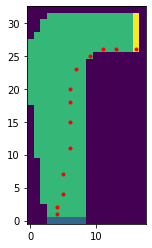

In [69]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = mc_1.generate_episode(mc_1.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -11


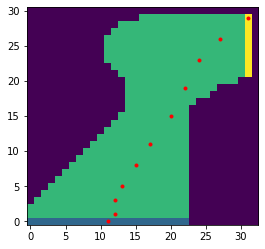

In [14]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = mc_2.generate_episode(mc_2.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -13


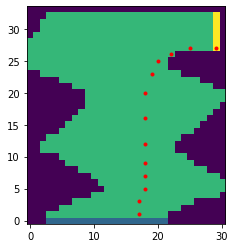

In [146]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()


trajectory = mc_3.generate_episode(mc_3.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

## Temporal Difference (SARSA on policy control)

Next we create another class over the environment class to perform the **Temporal Difference control**. Here we use the SARSA on policy TD control with one step lookahead i.e. TD(0). This class supports the following operations <br>
- `SARSA.generate_episode(policy)`: Given a policy this method generates an episode as a list of Transitions
- `SARSA.epsilon_greedy_policy(state)`: Here we also implement the $\epsilon$-$greedy$ strategy for policy improvement. Under the $\epsilon$-$greedy$ strategy the car choses the optimal action with probability $1-\epsilon$ and with probability $\epsilon$ it choses any action randomly.
- `SARSA.optimize(n_iter)`: This performs the SARSA on policy control with the on policy updation rule.  The number of episodes is denoted by **n_iter**.
- `SARSA.opt_policy(n_iter)`: Creates the optimal policy upto **n_iter** iterations. This method is used for MSE computation.<br>

- Here we have kept the discounting rate $\gamma$=$0.99$
- Here we have kept the learning rate as $\alpha$=$0.5$.
- The default value of $\epsilon$ is $0.2$

In [0]:
class SARSA(object):
    def __init__(self, env, gamma=0.99, epsilon = 0.2, alpha = 0.5):
        self.env = env
        self._policy = {}
        self._Q = defaultdict(lambda: defaultdict(int))                         # Value-Action pairs are stored as defaultdict -> Q[s][a]               
        self._C = defaultdict(lambda: defaultdict(int))                         # Counts corresponding the Value-Action pairs -> C[s][a]
        self.pi = defaultdict(lambda: defaultdict(int))                         # Optimal policy stored as defaultdict -> pi[s][a]
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
    
    def generate_episode(self, policy):                                         
        s = env.reset()                                                         # The starting state is chosen randomly with velocity components as zero
        trajectory = []
        while True:
            a = policy(s)
            s2, r, term, _ = self.env.step(a)
            t = Transition(s, a, r, s2)
            trajectory.append(t)
            if term:
                break                                                           # The episode ends only when the car hits the Finishing line
            s = s2                                                              # The episode continues even if the car hits boundary, and it starts again
        return trajectory
    
    def epsilon_greedy_policy(self, state):
        if state in self._Q:
            if np.random.rand(1)[0] > self.epsilon:                             # Selects the optimal action with prob. 1-eps
              return max(self._Q[state], key=self._Q[state].get)
            else:
              return random.choice(self.env.actions)                            # Selects any random action with prob. eps
        else:
            return random.choice(self.env.actions)
    
    def optimize(self, n_iter):
        for _ in tqdm(range(n_iter)):
            s = env.reset()  
            a = self.epsilon_greedy_policy(s)
            while not self.env._has_finished(s):
                s2, r, term, _ = self.env.step(a)
                a2 = self.epsilon_greedy_policy(s2)
                self._Q[s][a] = self._Q[s][a] + self.alpha * (r + self._Q[s2][a2] - self._Q[s][a])
                s = s2
                a = a2

    def opt_policy(self, n_iter, True_dict):
        mse_array_1 = []
        for _ in tqdm(range(n_iter)):
            s = env.reset()  
            a = self.epsilon_greedy_policy(s)
            mse_array_2 = []                                                    # mse_array_2 contains all the squared errors after updating each episode
            while not self.env._has_finished(s):
                s2, r, term, _ = self.env.step(a)
                a2 = self.epsilon_greedy_policy(s2)
                self._Q[s][a] = self._Q[s][a] + self.alpha * (r + self._Q[s2][a2] - self._Q[s][a])
                s = s2
                a = a2
                self.pi[s] = self._Q[s][max(self._Q[s], key=self._Q[s].get)]
                try:
                  best_known = True_dict[s][max(True_dict[s], key=True_dict[s].get)]
                except ValueError:
                  best_known = self.pi[s]  
                mse_array_2.append(np.square(best_known - self.pi[s]))
            mse_array_1.append(np.sqrt(np.mean(mse_array_2)))                   # mse_array_1 contains the averaged mse values for each iteration                                            
        return mse_array_1                                                      # array of MSE values for each iteration



In [0]:
env = Racetrack(track1)
td_1 = SARSA(env)

In [153]:
# We train the model with SARSA control for 500000 simulated episodes
start = time.time()
td_1.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [12:27<00:00, 668.97it/s]

Total training time 747.4235382080078


In [0]:
env = Racetrack(track2)
td_2 = SARSA(env)

In [17]:
# We train the model with SARSA control for 500000 simulated episodes
start = time.time()
td_2.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [08:31<00:00, 977.74it/s] 

Total training time 511.3896358013153


In [0]:
env = Racetrack(track3)
td_3 = SARSA(env)

In [149]:
# We train the model with SARSA control for 500000 simulated episodes
start = time.time()
td_3.optimize(500000)
end = time.time()
print("Total training time",end-start)

100%|██████████| 500000/500000 [13:46<00:00, 604.73it/s]

Total training time 826.8212282657623


The following is a visual representation of the trained policy after 500000 episodes. We generate a new episode using $\epsilon$-$greedy$ strategy on the optimal policy.



return -10


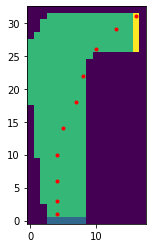

In [154]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = td_1.generate_episode(td_1.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -9


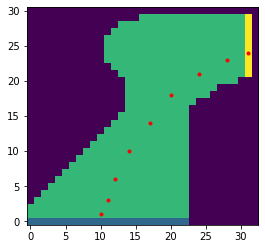

In [17]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = td_2.generate_episode(td_2.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -15


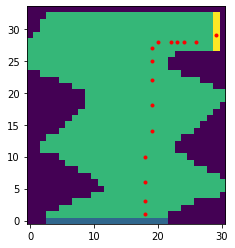

In [150]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = td_3.generate_episode(td_3.epsilon_greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

## Comparison between MC and TD methods 

In [0]:
# We store the State-Action value functions obtained after 500000 episodes
# Consider these as the TRUE state-action value functions
mc_dict_2 = mc_2._Q
td_dict_2 = td_2._Q

Generating the plot for studying the convergence rate

We take the policy obtained after training over 500000 episodes, as the optimal (**True**) policy. Next we use the `opt_policy` method to calculate the MSE for MC and TD separetely for each iteration. It is to be noted that, before using `opt_policy` each time we have to initialize the environment class with suitable $\alpha$ or $epsilon$ values.<br>
We plot the convergence rate of the 2 policies as follows:

In [54]:
mse_mc = mc_2.opt_policy(1000, mc_dict_2)
mse_td = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:10<00:00, 99.55it/s]


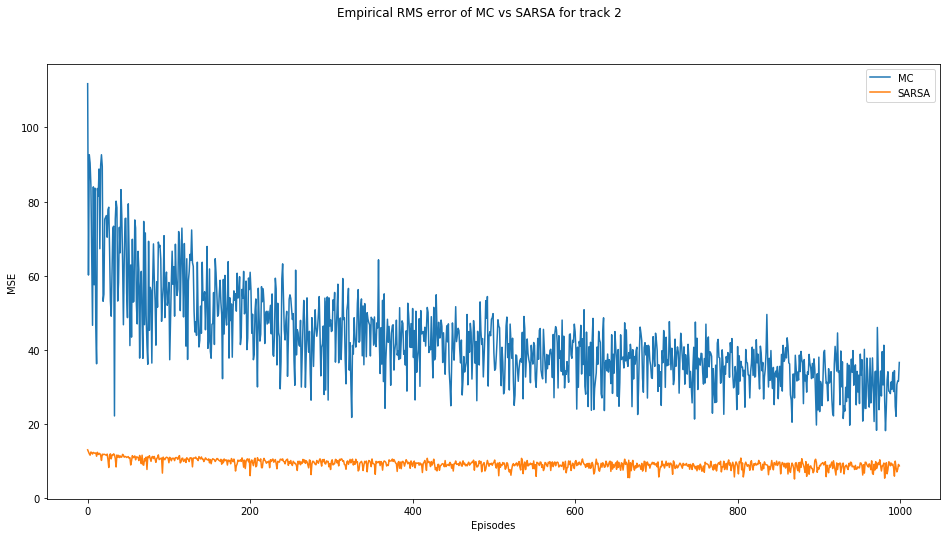

In [104]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1000)

plt.figure(figsize=(16,8))
plt.plot(x, mse_mc, '-')
plt.plot(x, mse_td, '-')
plt.suptitle('Empirical RMS error of MC vs SARSA for track 2')
plt.xlabel('Episodes')
plt.ylabel('MSE')

plt.legend(['MC', 'SARSA'], loc='upper right')

plt.show()

The above Graph plots the MSE with the following configration:
- $\epsilon = 0.2$ for the greedy policy<br>
- learning rate $\alpha$ is a constaht $0.5$ for SARSA and for MC we have used $1/n$ as the non-constant learning rate.
- dicscounting rate was $\gamma$=$0.99$
- *track2* was used

## Comparison of MC control for different values of $\alpha$ and $\epsilon$

In [93]:
mse_mc_alpha_01 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:19<00:00, 51.69it/s]


In [97]:
mse_mc_alpha_05 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:14<00:00, 69.81it/s]


In [83]:
mse_mc_alpha_1 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:13<00:00, 76.26it/s]


In [86]:
mse_mc_alpha_5 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


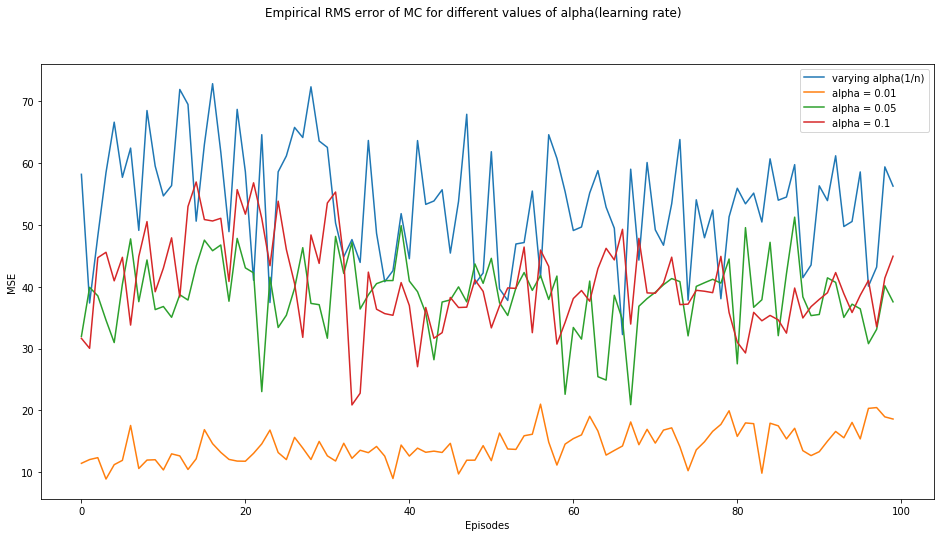

In [106]:
x = np.arange(100)

plt.figure(figsize=(16,8))
plt.plot(x, mse_mc[100:200], '-')
plt.plot(x, mse_mc_alpha_01[100:200], '-')
plt.plot(x, mse_mc_alpha_05[100:200], '-')
plt.plot(x, mse_mc_alpha_1[100:200], '-')
plt.suptitle('Empirical RMS error of MC for different values of alpha(learning rate)')
plt.xlabel('Episodes')
plt.ylabel('MSE')

plt.legend(['varying alpha(1/n)', 'alpha = 0.01', 'alpha = 0.05', 'alpha = 0.1'], loc='upper right')

plt.show()

The above Graph plots the MSE for MC control with different values of alpha:
<br>we took $\alpha$=$1/n$, $0.01$, $0.05$, $0.1$
- for fixed $\epsilon = 0.2$ for the greedy policy
- dicscounting rate was $\gamma$=$0.99$
- total $100$ episodes were used
- *track2* was used

In [117]:
mse_mc_eps_1 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:03<00:00, 301.69it/s]


In [109]:
mse_mc_eps_3 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:09<00:00, 109.80it/s]


In [112]:
mse_mc_eps_5 = mc_2.opt_policy(1000, mc_dict_2)

100%|██████████| 1000/1000 [00:15<00:00, 65.45it/s]


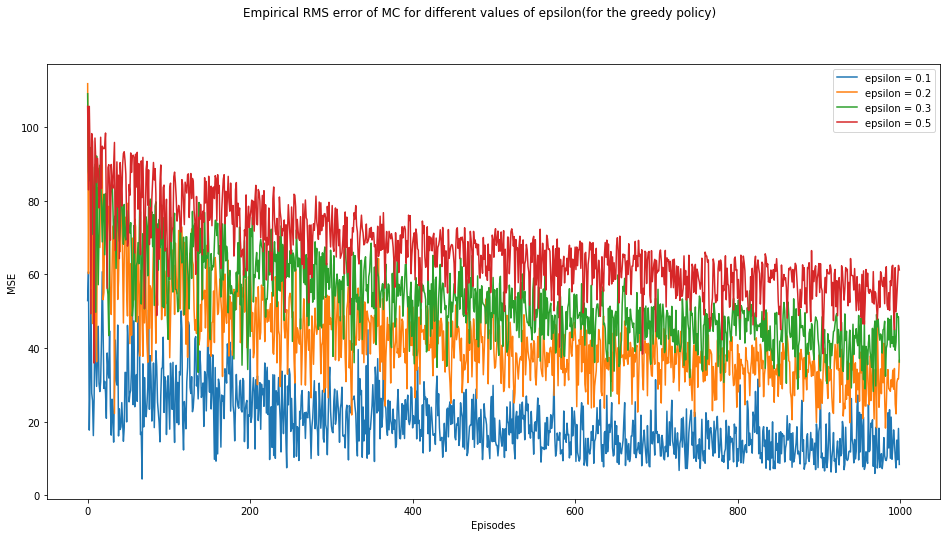

In [119]:
x = np.arange(1000)

plt.figure(figsize=(16,8))
plt.plot(x, mse_mc_eps_1, '-')
plt.plot(x, mse_mc, '-')
plt.plot(x, mse_mc_eps_3, '-')
plt.plot(x, mse_mc_eps_5, '-')
plt.suptitle('Empirical RMS error of MC for different values of epsilon(for the greedy policy)')
plt.xlabel('Episodes')
plt.ylabel('MSE')

plt.legend(['epsilon = 0.1', 'epsilon = 0.2', 'epsilon = 0.3', 'epsilon = 0.5'], loc='upper right')

plt.show()

The above Graph plots the MSE for MC control with different values of epsilon:
<br>we took $\epsilon$=$0.1$, $0.2$, $0.3$, $0.5$
- with $\alpha = 1/n$ learning rate
- dicscounting rate was $\gamma$=$0.99$
- total $100$ episodes were used
- *track2* was used

## Comparison of SARSA on policy control for different values of $\alpha$ and $\epsilon$

In [122]:
mse_td_alpha_01 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:24<00:00, 41.36it/s]


In [125]:
mse_td_alpha_05 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:20<00:00, 48.21it/s]


In [128]:
mse_td_alpha_1 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:16<00:00, 59.75it/s]


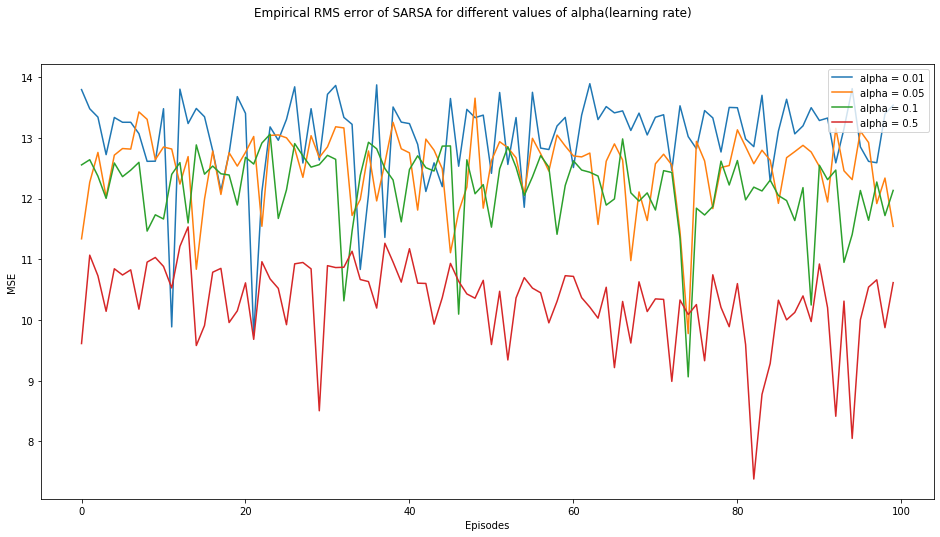

In [131]:
x = np.arange(100)

plt.figure(figsize=(16,8))
plt.plot(x, mse_td_alpha_01[100:200], '-')
plt.plot(x, mse_td_alpha_05[100:200], '-')
plt.plot(x, mse_td_alpha_1[100:200], '-')
plt.plot(x, mse_td[100:200], '-')
plt.suptitle('Empirical RMS error of SARSA for different values of alpha(learning rate)')
plt.xlabel('Episodes')
plt.ylabel('MSE')

plt.legend(['alpha = 0.01', 'alpha = 0.05', 'alpha = 0.1', 'alpha = 0.5' ], loc='upper right')

plt.show()

The above Graph plots the MSE for SARSA on policy control with different values of alpha:
<br>we took $\alpha$ = $0.01$, $0.05$, $0.1$, $0.5$
- for fixed $\epsilon = 0.2$ for the greedy policy
- dicscounting rate was $\gamma$=$0.99$
- total $100$ episodes were used
- *track2* was used

In [134]:
mse_td_eps_1 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:08<00:00, 287.88it/s]


In [137]:
mse_td_eps_3 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:10<00:00, 95.88it/s]


In [140]:
mse_td_eps_5 = td_2.opt_policy(1000, td_dict_2)

100%|██████████| 1000/1000 [00:13<00:00, 75.17it/s]


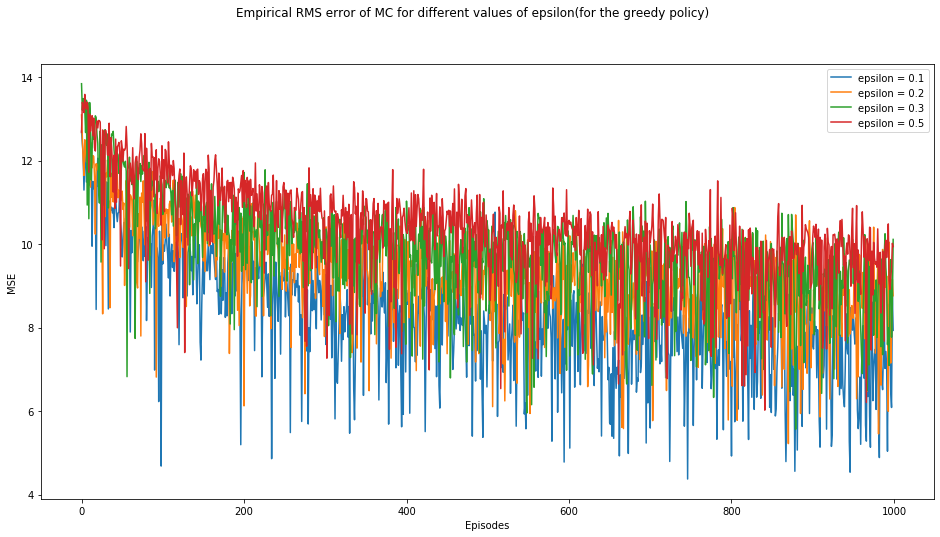

In [141]:
x = np.arange(1000)

plt.figure(figsize=(16,8))
plt.plot(x, mse_td_eps_1, '-')
plt.plot(x, mse_td, '-')
plt.plot(x, mse_td_eps_3, '-')
plt.plot(x, mse_td_eps_5, '-')
plt.suptitle('Empirical RMS error of MC for different values of epsilon(for the greedy policy)')
plt.xlabel('Episodes')
plt.ylabel('MSE')

plt.legend(['epsilon = 0.1', 'epsilon = 0.2', 'epsilon = 0.3', 'epsilon = 0.5'], loc='upper right')

plt.show()

The above Graph plots the MSE for SARSA on policy control with different values of epsilon:
<br>we took $\epsilon$=$0.1$, $0.2$, $0.3$, $0.5$
- with $\alpha = 0.5$ learning rate
- dicscounting rate was $\gamma$=$0.99$
- total $100$ episodes were used
- *track2* was used

The above comparison graphs can also be accessed with the link below :<br>
https://drive.google.com/open?id=1c3VqvaTyCrwiT6fxt1cVaAQh4ZVUb4Ka